In [1]:
!pip install tensorflow pandas numpy matplotlib yahoo_fin sklearn
!pip install requests_html

     |████████████████████████████████| 1.2MB 20.2MB/s 
     |████████████████████████████████| 81kB 10.6MB/s 
  Created wheel for pyppeteer: filename=pyppeteer-0.0.25-cp36-none-any.whl size=78362 sha256=0a8ba9c17d9ae8031796946c2e9fd78937f06303e70ae2154256a20f8d6dd6e8
  Stored in directory: /root/.cache/pip/wheels/34/e0/5d/070e22eceecf7ecd5fa4b86bbc18c1c7d0b90e02e9b57f35eb
  Created wheel for fake-useragent: filename=fake_useragent-0.1.11-cp36-none-any.whl size=13485 sha256=62cf5b373878b6f98ec700b6cc72500e092eeaa30780e7b395b75c9206ee12f1
  Stored in directory: /root/.cache/pip/wheels/5e/63/09/d1dc15179f175357d3f5c00cbffbac37f9e8690d80545143ff
  Created wheel for parse: filename=parse-1.14.0-cp36-none-any.whl size=23463 sha256=0bccf6649e0e6df6c7e8703ddcc8ec05e4c5018cb1896c1cfa9b3b43739e28bc
  Stored in directory: /root/.cache/pip/wheels/d7/07/e0/b74bfdc1d434e73ef79e69e301e82a7825e0c070f7442beb61
Successfully built pyppeteer fake-useragent parse


In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from yahoo_fin import stock_info as si
from collections import deque
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import time
import os


In [3]:
'''
We are using yahoo_fin module, it is essentially a Python scraper that
extracts finance data from Yahoo Finance platform, so it isn't a reliable API,
feel free to use other data sources such as Alpha Vantage.


'''

"\nWe are using yahoo_fin module, it is essentially a Python scraper that\nextracts finance data from Yahoo Finance platform, so it isn't a reliable API,\nfeel free to use other data sources such as Alpha Vantage.\n\n\n"

In [0]:
#Preparing the Dataset
#The following function will downloads the dataset from the Internet and preprocess it:

def load_data(ticker, n_steps=50, scale=True, shuffle=True, lookup_step=1, 
                test_size=0.2, feature_columns=['adjclose', 'volume', 'open', 'high', 'low']):
    # see if ticker is already a loaded stock from yahoo finance
    if isinstance(ticker, str):
        # load it from yahoo_fin library
        df = si.get_data(ticker)
    elif isinstance(ticker, pd.DataFrame):
        # already loaded, use it directly
        df = ticker
    # this will contain all the elements we want to return from this function
    result = {}
    # we will also return the original dataframe itself
    result['df'] = df.copy()
    # make sure that the passed feature_columns exist in the dataframe
    for col in feature_columns:
        assert col in df.columns
    if scale:
        column_scaler = {}
        # scale the data (prices) from 0 to 1
        for column in feature_columns:
            scaler = preprocessing.MinMaxScaler()
            df[column] = scaler.fit_transform(np.expand_dims(df[column].values, axis=1))
            column_scaler[column] = scaler

        # add the MinMaxScaler instances to the result returned
        result["column_scaler"] = column_scaler
    # add the target column (label) by shifting by `lookup_step`
    df['future'] = df['adjclose'].shift(-lookup_step)
    # last `lookup_step` columns contains NaN in future column
    # get them before droping NaNs
    last_sequence = np.array(df[feature_columns].tail(lookup_step))
    # drop NaNs
    df.dropna(inplace=True)
    sequence_data = []
    sequences = deque(maxlen=n_steps)
    for entry, target in zip(df[feature_columns].values, df['future'].values):
        sequences.append(entry)
        if len(sequences) == n_steps:
            sequence_data.append([np.array(sequences), target])
    # get the last sequence by appending the last `n_step` sequence with `lookup_step` sequence
    # for instance, if n_steps=50 and lookup_step=10, last_sequence should be of 59 (that is 50+10-1) length
    # this last_sequence will be used to predict in future dates that are not available in the dataset
    last_sequence = list(sequences) + list(last_sequence)
    # shift the last sequence by -1
    last_sequence = np.array(pd.DataFrame(last_sequence).shift(-1).dropna())
    # add to result
    result['last_sequence'] = last_sequence
    # construct the X's and y's
    X, y = [], []
    for seq, target in sequence_data:
        X.append(seq)
        y.append(target)
    # convert to numpy arrays
    X = np.array(X)
    y = np.array(y)
    # reshape X to fit the neural network
    X = X.reshape((X.shape[0], X.shape[2], X.shape[1]))
    # split the dataset
    result["X_train"], result["X_test"], result["y_train"], result["y_test"] = train_test_split(X, y, test_size=test_size, shuffle=shuffle)
    # return the result
    return result


In [0]:
#Model Creation
def create_model(input_length, units=256, cell=LSTM, n_layers=2, dropout=0.3,
                loss="mean_absolute_error", optimizer="rmsprop"):
    model = Sequential()
    for i in range(n_layers):
        if i == 0:
            # first layer
            model.add(cell(units, return_sequences=True, input_shape=(None, input_length)))
        elif i == n_layers - 1:
            # last layer
            model.add(cell(units, return_sequences=False))
        else:
            # hidden layers
            model.add(cell(units, return_sequences=True))
        # add dropout after each layer
        model.add(Dropout(dropout))
    model.add(Dense(1, activation="linear"))
    model.compile(loss=loss, metrics=["mean_absolute_error"], optimizer=optimizer)
    return model


In [0]:
#Training our Model
# Window size or the sequence length
N_STEPS = 50
# Lookup step, 1 is the next day
LOOKUP_STEP = 1
# test ratio size, 0.2 is 20%
TEST_SIZE = 0.2
# features to use
FEATURE_COLUMNS = ["adjclose", "volume", "open", "high", "low"]
# date now
date_now = time.strftime("%Y-%m-%d")
### model parameters
N_LAYERS = 3
# LSTM cell
CELL = LSTM
# 256 LSTM neurons
UNITS = 256
# 40% dropout
DROPOUT = 0.4
### training parameters
# mean squared error loss
LOSS = "mse"
OPTIMIZER = "rmsprop"
BATCH_SIZE = 64
EPOCHS = 300
# Apple stock market
ticker = "AAPL"
ticker_data_filename = os.path.join("data", f"{ticker}_{date_now}.csv")
# model name to save
model_name = f"{date_now}_{ticker}-{LOSS}-{CELL.__name__}-seq-{N_STEPS}-step-{LOOKUP_STEP}-layers-{N_LAYERS}-units-{UNITS}"

# create these folders if they does not exist
if not os.path.isdir("results"):
    os.mkdir("results")
if not os.path.isdir("logs"):
    os.mkdir("logs")
if not os.path.isdir("data"):
    os.mkdir("data")


In [0]:
# load the CSV file from disk (dataset) if it already exists (without downloading)
if os.path.isfile(ticker_data_filename):
    ticker = pd.read_csv(ticker_data_filename)


In [8]:
# load the data
data = load_data(ticker, N_STEPS, lookup_step=LOOKUP_STEP, test_size=TEST_SIZE, feature_columns=FEATURE_COLUMNS)
if not os.path.isfile(ticker_data_filename):
    # save the CSV file (dataset)
    data["df"].to_csv(ticker_data_filename)
# construct the model
model = create_model(N_STEPS, loss=LOSS, units=UNITS, cell=CELL, n_layers=N_LAYERS,
                    dropout=DROPOUT, optimizer=OPTIMIZER)
# some tensorflow callbacks
checkpointer = ModelCheckpoint(os.path.join("results", model_name), save_best_only=True, verbose=1)
tensorboard = TensorBoard(log_dir=os.path.join("logs", model_name))

history = model.fit(data["X_train"], data["y_train"],
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_data=(data["X_test"], data["y_test"]),
                    callbacks=[checkpointer, tensorboard],
                    verbose=1)
model.save(os.path.join("results", model_name) + ".h5")


Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 7852 samples, validate on 1964 samples
Epoch 1/300
7680/7852 [============================>.] - ETA: 0s - loss: 0.0035 - mean_absolute_error: 0.0265
Epoch 00001: val_loss improved from inf to 0.00041, saving model to results/2020-02-03_AAPL-mse-LSTM-seq-50-step-1-layers-3-units-256
7852/7852 [==============================] - 6s 797us/sample - loss: 0.0035 - mean_absolute_error: 0.0261 - val_loss: 4.1316e-04 - val_mean_absolute_error: 0.0084
Epoch 2/300
7744/7852 [============================>.] - ETA: 0s - loss: 0.0019 - mean_absolute_error: 0.0202
Epoch 00002: val_loss did not improve from 0.00041
7852/7852 [==============================] - 3s 382us/sample - loss: 0.0018 - mean_absolute_error: 0.0201 - val_loss: 0.0010 - val_mean_absolute_error: 0.0157
Epoch 3/300
7808/7852 [===========================

In [10]:
#Testing the Model
# evaluate the model
mse, mae = model.evaluate(data["X_test"], data["y_test"])
# calculate the mean absolute error (inverse scaling)
mean_absolute_error = data["column_scaler"]["adjclose"].inverse_transform(mae.reshape(1, -1))[0][0]
print("Mean Absolute Error:", mean_absolute_error)


1964/1964 [==============================] - 0s 201us/sample - loss: 8.2622e-05 - mean_absolute_error: 0.0056
Mean Absolute Error: 1.9642618


In [0]:
#let's try to predict the future price of Apple Stock Market:
def predict(model, data, classification=False):
    # retrieve the last sequence from data
    last_sequence = data["last_sequence"][:N_STEPS]
    # retrieve the column scalers
    column_scaler = data["column_scaler"]
    # reshape the last sequence
    last_sequence = last_sequence.reshape((last_sequence.shape[1], last_sequence.shape[0]))
    # expand dimension
    last_sequence = np.expand_dims(last_sequence, axis=0)
    # get the prediction (scaled from 0 to 1)
    prediction = model.predict(last_sequence)
    # get the price (by inverting the scaling)
    predicted_price = column_scaler["adjclose"].inverse_transform(prediction)[0][0]
    return predicted_price


In [12]:
# predict the future price
future_price = predict(model, data)
print(f"Future price after {LOOKUP_STEP} days is {future_price:.2f}$")


Future price after 1 days is 320.48$


In [0]:
#The last price was 298.45$, the model is saying that the next day,
#it will be 308.20$. The model just used 50 days of features to be able to get that value, 
#Now plot the prices and see:
def plot_graph(model, data):
    y_test = data["y_test"]
    X_test = data["X_test"]
    y_pred = model.predict(X_test)
    y_test = np.squeeze(data["column_scaler"]["adjclose"].inverse_transform(np.expand_dims(y_test, axis=0)))
    y_pred = np.squeeze(data["column_scaler"]["adjclose"].inverse_transform(y_pred))
    plt.plot(y_test[-200:], c='b')
    plt.plot(y_pred[-200:], c='r')
    plt.xlabel("Days")
    plt.ylabel("Price")
    plt.legend(["Actual Price", "Predicted Price"])
    plt.show()



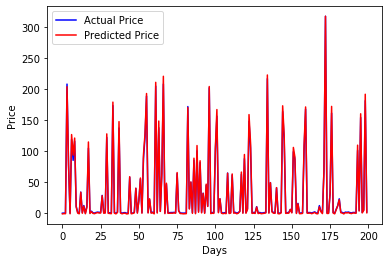

In [14]:
plot_graph(model, data)


In [0]:
def get_accuracy(model, data):
    y_test = data["y_test"]
    X_test = data["X_test"]
    y_pred = model.predict(X_test)
    y_test = np.squeeze(data["column_scaler"]["adjclose"].inverse_transform(np.expand_dims(y_test, axis=0)))
    y_pred = np.squeeze(data["column_scaler"]["adjclose"].inverse_transform(y_pred))
    y_pred = list(map(lambda current, future: int(float(future) > float(current)), y_test[:-LOOKUP_STEP], y_pred[LOOKUP_STEP:]))
    y_test = list(map(lambda current, future: int(float(future) > float(current)), y_test[:-LOOKUP_STEP], y_test[LOOKUP_STEP:]))
    return accuracy_score(y_test, y_pred)



In [17]:
print("Accuracy Score:", get_accuracy(model, data))



Accuracy Score: 0.8537952114111055
